In [1]:
#!pip install scikit-learn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data_train = pd.read_csv('../data_cleaned/data_train.csv')
item_categories = pd.read_csv('../data_cleaned/item_categories.csv')
items = pd.read_csv('../data_cleaned/items.csv')
shops = pd.read_csv('../data_cleaned/shops.csv')

In [3]:
#merged = data_train.merge(items, how='left').merge(item_categories, how='left').merge(shops, how='left')

In [4]:
def parse_city(shop_name):
    if shop_name.split()[0] == '!Якутск':
        return  'Якутск'

    if shop_name.split()[0] == 'Сергиев':
            return  'Сергиев Посад'
    else:
        return shop_name.split()[0]

In [5]:
#dates = pd.to_datetime(data_train['date'], format='%d.%m.%Y')


In [6]:
grouped=data_train.groupby(['shop_id','item_id','date_block_num']).agg({'item_price':'mean',
                                                                    'item_cnt_day':'sum'
                                                                    })#take some (a lot)))) ) time

In [7]:
grouped

item_price  item_cnt_day
shop_id item_id date_block_num                          
2       27      0                   2499.0           1.0
                17                   498.0           1.0
        30      2                    359.0           1.0
                5                    399.0           1.0
                15                   169.0           1.0
...                                    ...           ...
59      22164   27                   699.0           2.0
                30                   699.0           1.0
        22167   9                    299.0           1.0
                11                   299.0           2.0
                17                   299.0           1.0

[1608225 rows x 2 columns]

In [8]:
grouped=grouped.reset_index()

In [9]:
grouped

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,2,27,0,2499.0,1.0
1,2,27,17,498.0,1.0
2,2,30,2,359.0,1.0
3,2,30,5,399.0,1.0
4,2,30,15,169.0,1.0
...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0
1608221,59,22164,30,699.0,1.0
1608222,59,22167,9,299.0,1.0
1608223,59,22167,11,299.0,2.0


In [10]:
merged = grouped.merge(items, how='left').merge(item_categories, how='left').merge(shops, how='left')

In [11]:
merged.isna().sum()

shop_id               0
item_id               0
date_block_num        0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

In [12]:
import calendar

def number_to_month(numbers):
    # Create a list of month names using the calendar module
    month_names = list(calendar.month_name)[1:]  # Extract months from 1 to 12 (exclude the empty element at index 0)
    
    # Convert the numbers to month names
    result = [month_names[num % 12] for num in numbers]  # Use num % 12 to handle numbers beyond 11
    
    return result


In [13]:

def number_to_month(numbers):
    result = [num %12 for num in numbers]  # Use num % 12 to handle numbers beyond 11
    
    return result


In [14]:
def convert_to_year(month_num):
    # January 2013 is the starting point
    start_year = 2013
    
    # Calculate the year
    year = start_year + (month_num // 12)
    
    return year

In [15]:
merged['month'] = number_to_month(merged['date_block_num'])
merged['year'] = merged['date_block_num'].apply(convert_to_year)

In [16]:
merged['super_category'] = merged['item_category_name'].apply(lambda a: a.split()[0])

In [17]:

merged['city'] = merged['shop_name'].apply(parse_city)

In [18]:
#merged = merged.drop(['shop_id','item_id','item_category_id'],axis=1)

In [19]:
merged=merged.rename(columns={'item_price':'avg_item_price','item_cnt_day':'item_cnt_month'})

In [20]:
item_lags=list([*range(1,7),12,13,24])
price_lags=list([*range(1,7),12,24])

In [21]:

def create_lags(data,item_lags=None,price_lags=None):
    lagged_items = data[['date_block_num','item_cnt_month','shop_id','item_id']].copy()
    for lag in item_lags:
        lagged_items['date_block_num']-=lag#previous month becomes present
        data=data.merge(lagged_items, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        lagged_items['date_block_num']+=lag

    lagged_prices = data[['date_block_num','avg_item_price','shop_id','item_id']].copy()
    for lag in price_lags:
        lagged_prices['date_block_num']-=lag#previous month becomes present
        data=data.merge(lagged_prices, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        lagged_prices['date_block_num']+=lag

        
    return data

In [23]:
lagged = create_lags(merged,item_lags=item_lags,price_lags=price_lags)#takes a bit time

In [22]:
lagged.isna().sum()

NameError: name 'lagged' is not defined

In [25]:
#lagged = lagged.drop(['avg_item_price'],axis=1)#we can't use it for train
lagged['shop_id_cat'] = lagged['shop_id'].astype('str')
lagged['item_id_cat'] = lagged['item_id'].astype('str')
lagged['item_category_id_cat'] = lagged['item_category_id'].astype('str')
#lagged = lagged.drop(['shop_id','item_id','item_name','shop_name','item_category_id','item_category_name'],axis=1)


In [26]:
lagged.columns

Index(['shop_id', 'item_id', 'date_block_num', 'avg_item_price',
       'item_cnt_month', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'month', 'year', 'super_category', 'city',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'item_cnt_month_lag_13',
       'item_cnt_month_lag_24', 'avg_item_price_lag_1', 'avg_item_price_lag_2',
       'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5',
       'avg_item_price_lag_6', 'avg_item_price_lag_12',
       'avg_item_price_lag_24', 'shop_id_cat', 'item_id_cat',
       'item_category_id_cat'],
      dtype='object')

In [27]:
!pwd

/home/valeriy/python_projects/predict_future_sales/EDA


In [28]:
from sklearn.preprocessing import TargetEncoder

In [29]:
def encode_numerical_features(data, features):#Best way?? May be used for linear models
    te = TargetEncoder(target_type='continuous')
    transformed=te.fit_transform(data[features],y=data['item_cnt_month'])
    for idx,feature in enumerate(features):
        data[feature+'_trg_enc'] = transformed[:,idx]
    return data

In [30]:
lagged = encode_numerical_features(lagged, features=['item_category_id_cat', 'super_category','city'])#this part may not be used 

In [31]:
#Part of columns helpfull for trees. Part - for linear models

In [32]:
def find_mean_price(lagged):
    return lagged[[f'avg_item_price_lag_{lag}' for lag in price_lags[:6]]].mean(axis=1)
    

In [33]:
def find_mean_cnt(lagged):
    return lagged[[f'item_cnt_month_lag_{lag}' for lag in item_lags[:6]]].mean(axis=1)
    

In [34]:
lagged['mean_price_lag_6'] = find_mean_price(lagged)

In [35]:
lagged['mean_cnt_month_lag_6'] = find_mean_cnt(lagged)

In [36]:
lagged.columns


Index(['shop_id', 'item_id', 'date_block_num', 'avg_item_price',
       'item_cnt_month', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'month', 'year', 'super_category', 'city',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'item_cnt_month_lag_13',
       'item_cnt_month_lag_24', 'avg_item_price_lag_1', 'avg_item_price_lag_2',
       'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5',
       'avg_item_price_lag_6', 'avg_item_price_lag_12',
       'avg_item_price_lag_24', 'shop_id_cat', 'item_id_cat',
       'item_category_id_cat', 'item_category_id_cat_trg_enc',
       'super_category_trg_enc', 'city_trg_enc', 'mean_price_lag_6',
       'mean_cnt_month_lag_6'],
      dtype='object')

In [37]:
avg_by_month = lagged.groupby('date_block_num').agg({'item_cnt_month':'sum','avg_item_price':'mean'})

In [38]:
avg_by_month = avg_by_month.reset_index()

In [39]:
import matplotlib.pyplot as plt

In [40]:
avg_by_month

,date_block_num,item_cnt_month,avg_item_price
0,0,131849.0,650.988408
1,1,128382.0,635.958190
2,2,147438.0,643.699903
3,3,107439.0,631.966626
4,4,107147.0,614.503063
5,5,125583.0,610.268881
6,6,117165.0,594.408236
7,7,125586.0,606.867867
8,8,133551.0,687.691894
9,9,127815.0,713.439445


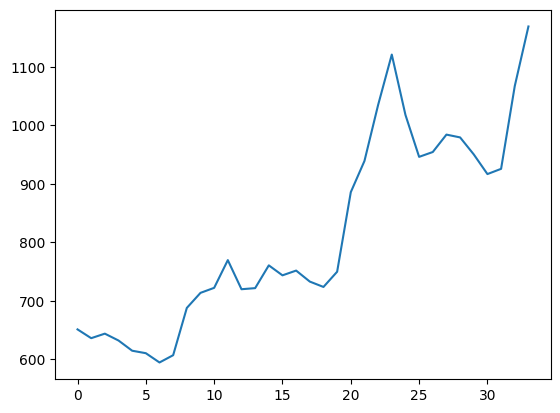

In [41]:
plt.plot(avg_by_month['date_block_num'], avg_by_month['avg_item_price']);

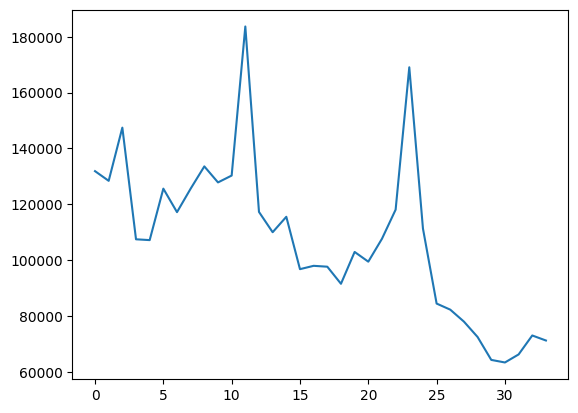

In [42]:
plt.plot(avg_by_month['date_block_num'], avg_by_month['item_cnt_month'])

In [43]:
avg_by_month = lagged

In [44]:
#avg_by_month = avg_by_month.reset_index()

In [45]:
avg_by_month.city.value_counts()

city
Москва              492478
Якутск              105991
Воронеж              82375
СПб                  78524
Тюмень               77193
Химки                70435
Уфа                  57984
Самара               50201
Красноярск           45685
Чехов                43860
Н.Новгород           38304
РостовНаДону         37321
Сергиев Посад        36649
Курск                36603
Казань               34945
Сургут               32018
Калуга               31772
Коломна              31282
Омск                 26092
Новосибирск          25930
Ярославль            25077
Вологда              24099
Волжский             23718
Интернет-магазин     20578
Балашиха             16818
Адыгея               15541
Жуковский            15288
Томск                13567
Цифровой             12766
Мытищи                3541
Выездная              1590
Name: count, dtype: int64

In [46]:
def plot_colored_lines(data=None,x_name=None,y_name=None,hue_name=None,ylim=50000):
    """
    parameters are column names
    """
    # Set plot style
    sns.set(style="whitegrid")

    
    # Create the line plot
    plt.figure(figsize=(10, 6))
    line_plot=sns.lineplot(x=x_name, y=y_name, hue=hue_name, data=data, marker='o')
    legend_labels = [t.get_text() for t in plt.gca().get_legend().get_texts()]
    
    for i,line in enumerate(line_plot.get_lines()[0:len(line_plot.get_lines())//2]):
        # Get the label for the line (super_category)
        label = line.get_label()
        
        # Get the x and y data from the line
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        #print(x_data)
        # Place the label at the last point of the line
        if ylim is None:
            if len(x_data) > 0:
                plt.text(x_data[-1] + 0.1, y_data[-1], legend_labels[i], horizontalalignment='left', size='small', color=line.get_color())
        elif len(x_data) > 0 and y_data[-1] <= ylim:
            plt.text(x_data[-1] + 0.1, y_data[-1], legend_labels[i], horizontalalignment='left', size='small', color=line.get_color())

    
    # Add labels and title
    #plt.title('Item Count per Moth by Category')
    plt.xlabel(x_name)
    plt.ylabel(y_name)

    plt.ylim(0,ylim)
    # Show the plot
    plt.legend('',frameon=False)
    plt.show()

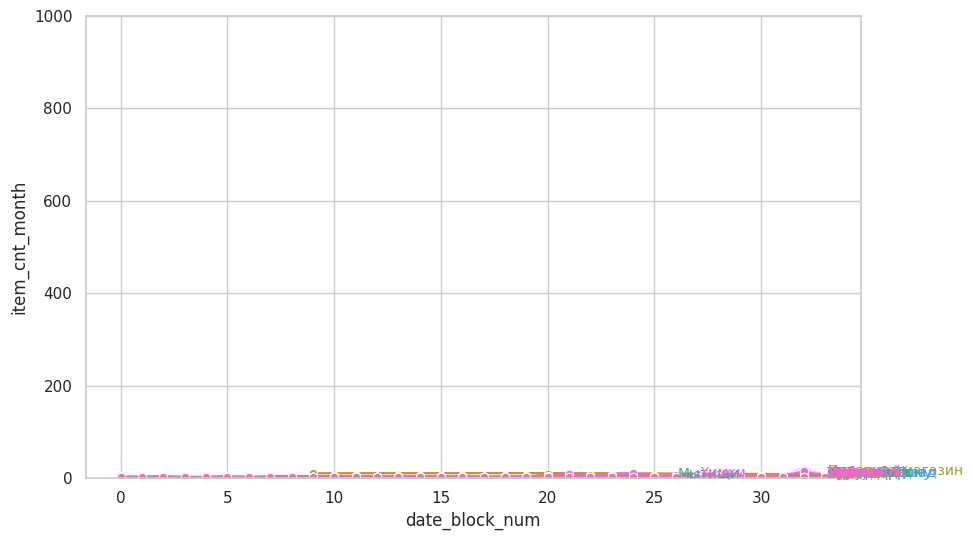

In [48]:
plot_colored_lines(avg_by_month, 'date_block_num','item_cnt_month', 'city',ylim=1000)

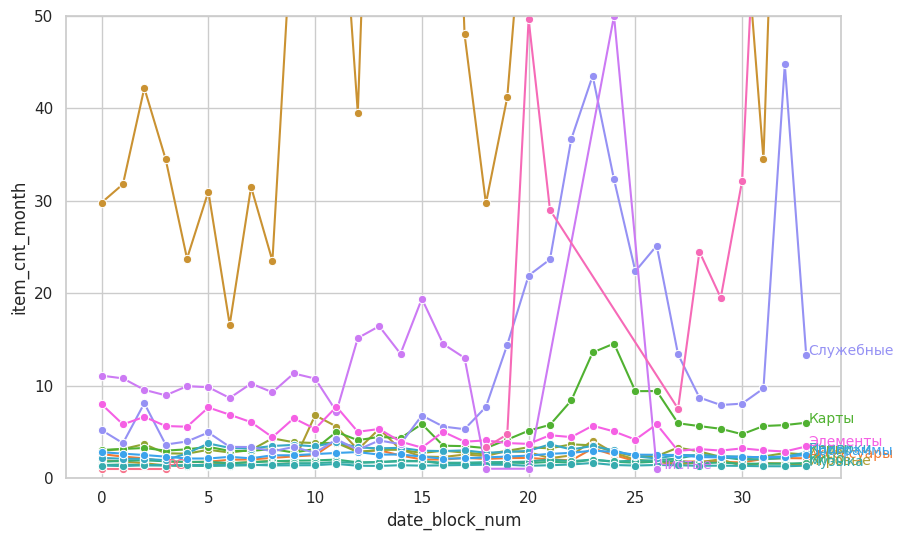

In [49]:
plot_colored_lines(avg_by_month.groupby(['date_block_num','super_category']).agg({'item_cnt_month':'mean'}), 'date_block_num','item_cnt_month', 'super_category',ylim=50)

In [50]:
avg = avg_by_month.groupby('city').agg({'item_cnt_month':'sum'}).reset_index().merge(
          avg_by_month.city.value_counts(), on='city'
)


In [51]:
avg

,city,item_cnt_month,count
0,Адыгея,30706.0,15541
1,Балашиха,28475.0,16818
2,Волжский,44069.0,23718
3,Вологда,42847.0,24099
4,Воронеж,171518.0,82375
5,Выездная,15874.0,1590
6,Жуковский,25095.0,15288
7,Интернет-магазин,73989.0,20578
8,Казань,66277.0,34945
9,Калуга,71331.0,31772


In [52]:
pd.concat([(avg['item_cnt_month'] / avg['count']) , avg['city']], ignore_index=True, axis=1)
#avarage sales in a city

,0,1
0,1.975806,Адыгея
1,1.693126,Балашиха
2,1.858040,Волжский
3,1.777958,Вологда
4,2.082161,Воронеж
5,9.983648,Выездная
6,1.641484,Жуковский
7,3.595539,Интернет-магазин
8,1.896609,Казань
9,2.245090,Калуга


In [21]:
gr = grouped.groupby(['shop_id','item_id']).agg({'date_block_num':'unique'})

In [22]:
(gr.reset_index()['date_block_num'].apply(lambda a:len(a)) == 1).sum() / len(gr.reset_index())
#33 percents of ('shop_id','item_id') have info only about 1 monyh

np.float64(0.3399191180332409)

In [23]:
gr = grouped.groupby(['item_id']).agg({'date_block_num':'unique'}).reset_index()

In [24]:
gr[gr['item_id'] == 22166]['date_block_num']

21799    [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...
Name: date_block_num, dtype: object

In [25]:

(gr.reset_index()['date_block_num'].apply(lambda a:len(a)) == 1).sum() / len(gr.reset_index())
#13 percents of ('item_id') have info only about 1 monyh

np.float64(0.13759574370499472)

In [26]:
df = merged

In [27]:
def avg(data):
    v = data['item_cnt_month'].mode().mean()

    return v#.mode()[0]#.mean()

In [28]:
def avg_by_city(data, city):
    v = data [data['city']==city] ['item_cnt_month'].mode().mean()
    
    return v# .mode()[0]

In [29]:
def avg_by_shop(data, shop):
    v = data [data['shop_id']==shop] ['item_cnt_month'].mode().mean()
    
    return v# .mode()[0]#.mean()

In [30]:
#df.groupby('item_category_id')['date_block_num'].transform('min')

In [31]:

# 1. Create the 'first_date_block_num' column (first appearance of each item_id)
df['first_date_block_num'] = df.groupby('item_id')['date_block_num'].transform('min')

# 2. Create the 'first_cat_block_num' column (first appearance of each item_category_id)
df['first_cat_block_num'] = df.groupby('item_category_id')['date_block_num'].transform('min')
df['first_sup_cat_block_num'] = df.groupby('super_category')['date_block_num'].transform('min')

# Display the DataFrame with the new columns
df[['item_id', 'item_category_id', 'date_block_num', 'first_date_block_num', 'first_cat_block_num']]

,item_id,item_category_id,date_block_num,first_date_block_num,first_cat_block_num
0,27,19,0,0,0
1,27,19,17,0,0
2,30,40,2,1,0
3,30,40,5,1,0
4,30,40,15,1,0
...,...,...,...,...,...
1608220,22164,37,27,25,0
1608221,22164,37,30,25,0
1608222,22167,49,9,8,0
1608223,22167,49,11,8,0


In [32]:

def create_lags_columns(data, columns,item_lags=[1,2,3],price_lags=[1,2,3]):
    
    lagged_items = data[[*columns,'item_cnt_month']]
    
    for lag in item_lags:
        lagged_items['date_block_num']-=lag#previous month becomes present

        averaged = lagged_items.groupby(columns).mean().reset_index()
        
        data=data.merge(averaged, how='left',on=columns, suffixes=('', f'{'_'.join(columns[1:])}_lag_{lag}'))
        
        lagged_items['date_block_num']+=lag

    lagged_prices = data[[*columns,'avg_item_price']]
    for lag in price_lags:
        lagged_prices['date_block_num']-=lag#previous month becomes present

        averaged = lagged_prices.groupby(columns).mean().reset_index()
        
        data=data.merge(averaged, how='left',on=columns, suffixes=('', f'{'_'.join(columns[1:])}_lag_{lag}'))
        lagged_prices['date_block_num']+=lag

        
    return data

In [33]:
df = create_lags_columns(df,columns=['date_block_num','super_category'] )

/tmp/ipykernel_35551/3987657818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_items['date_block_num']-=lag#previous month becomes present
/tmp/ipykernel_35551/3987657818.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_items['date_block_num']+=lag
/tmp/ipykernel_35551/3987657818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [34]:
df = create_lags_columns(df,columns=['date_block_num','item_id'] )

/tmp/ipykernel_35551/3987657818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_items['date_block_num']-=lag#previous month becomes present
/tmp/ipykernel_35551/3987657818.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_items['date_block_num']+=lag
/tmp/ipykernel_35551/3987657818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [35]:
df = create_lags_columns(df,columns=['date_block_num','item_category_name'] )

/tmp/ipykernel_35551/3987657818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_items['date_block_num']-=lag#previous month becomes present
/tmp/ipykernel_35551/3987657818.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_items['date_block_num']+=lag
/tmp/ipykernel_35551/3987657818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [36]:
df = create_lags_columns(df,columns=['date_block_num','city'] )

/tmp/ipykernel_35551/3987657818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_items['date_block_num']-=lag#previous month becomes present
/tmp/ipykernel_35551/3987657818.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagged_items['date_block_num']+=lag
/tmp/ipykernel_35551/3987657818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [37]:
import pandas as pd

# Assuming your DataFrame is named 'df'

# Function to calculate EMA over the lag columns
def calculate_ema_3(df, min_periods=3, target='item_cnt_month'):
    #f'{'_'.join(columns[1:])}_lag_{lag}')
    # Create a temporary dataframe with the 3 lags
    def calculate_ema(df,group_col):
        lag_data = df[[f'{target}{group_col}_lag_1', f'{target}{group_col}_lag_2', f'{target}{group_col}_lag_3']]
        
        # Compute the row-wise EMA for the 3 lag columns using ewm
        ema_series = lag_data.ewm(alpha=0.5, min_periods=min_periods, axis=1).mean().mean(axis=1)
        
        return ema_series

    
    # Calculate EMA for 'item_category_name'
    df[f'ema_{target}_item_category_name'] = df.groupby('item_category_name').apply(lambda group: calculate_ema(group, 'item_category_name')).reset_index(drop=True)
    
    # Calculate EMA for 'item_id'
    df[f'ema_{target}_item_id'] = df.groupby('item_id').apply(lambda group: calculate_ema(group, 'item_id')).reset_index(drop=True)
    
    # Calculate EMA for 'super_category'
    df[f'ema_{target}_super_category'] = df.groupby('super_category').apply(lambda group: calculate_ema(group, 'super_category')).reset_index(drop=True)
    
    # Calculate EMA for 'city'
    df[f'ema_{target}_city'] = df.groupby('city').apply(lambda group: calculate_ema(group, 'city')).reset_index(drop=True)
    
    # The df will now have 4 new EMA columns based on the lag values

    return df


In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [39]:
df

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name,month,...,item_cnt_monthitem_category_name_lag_3,avg_item_priceitem_category_name_lag_1,avg_item_priceitem_category_name_lag_2,avg_item_priceitem_category_name_lag_3,item_cnt_monthcity_lag_1,item_cnt_monthcity_lag_2,item_cnt_monthcity_lag_3,avg_item_pricecity_lag_1,avg_item_pricecity_lag_2,avg_item_pricecity_lag_3
0,2,27,0,2499.0,1.0,"007 Legends [PS3, русская версия]",19,Игры - PS3,"Адыгея ТЦ ""Мега""",0,...,2.286054,1451.695728,1485.271200,1386.809111,1.513932,1.766355,1.462500,1070.128740,894.116413,1133.114571
1,2,27,17,498.0,1.0,"007 Legends [PS3, русская версия]",19,Игры - PS3,"Адыгея ТЦ ""Мега""",5,...,2.382036,1365.296578,1284.194489,1374.119054,2.031477,2.192661,2.458667,1122.024557,1087.679582,1310.066810
2,2,30,2,359.0,1.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"Адыгея ТЦ ""Мега""",2,...,1.870247,221.553726,219.647423,215.224815,1.462500,1.510929,1.789247,1133.114571,1028.788409,982.019701
3,2,30,5,399.0,1.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"Адыгея ТЦ ""Мега""",5,...,1.930448,210.422398,206.496104,212.573889,1.661191,1.714844,2.433333,1112.590257,1074.149602,1309.468904
4,2,30,15,169.0,1.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"Адыгея ТЦ ""Мега""",3,...,1.655567,222.822528,219.491526,220.232486,2.004396,2.162528,2.031477,1217.344039,1083.813753,1122.024557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0,ЯРОСТЬ (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",3,...,1.374011,460.855569,429.423072,403.227364,1.817822,1.681400,1.688663,886.015059,984.926987,934.520738
1608221,59,22164,30,699.0,1.0,ЯРОСТЬ (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",6,...,1.704650,391.203189,391.407945,390.787489,2.050590,1.863544,1.584000,894.792472,1136.298078,1082.476856
1608222,59,22167,9,299.0,1.0,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,"Ярославль ТЦ ""Альтаир""",9,...,1.965699,402.936990,398.443635,444.986807,2.250863,2.275142,1.775148,750.881170,743.321211,709.190804
1608223,59,22167,11,299.0,2.0,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,"Ярославль ТЦ ""Альтаир""",11,...,2.212471,444.986807,403.460258,427.819064,1.775148,1.997203,1.971925,709.190804,731.721848,816.896293


In [40]:
df = calculate_ema_3(df, target='avg_item_price')

/tmp/ipykernel_35551/3532761222.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'ema_{target}_item_category_name'] = df.groupby('item_category_name').apply(lambda group: calculate_ema(group, 'item_category_name')).reset_index(drop=True)
/tmp/ipykernel_35551/3532761222.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'ema_{target}_item_id'] = df.groupby('item_id').apply(lambda group: calcula

In [46]:
df = calculate_ema_3(df, target='item_cnt_month')

/tmp/ipykernel_35551/3532761222.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'ema_{target}_item_category_name'] = df.groupby('item_category_name').apply(lambda group: calculate_ema(group, 'item_category_name')).reset_index(drop=True)
/tmp/ipykernel_35551/3532761222.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'ema_{target}_item_id'] = df.groupby('item_id').apply(lambda group: calcula

In [41]:
#df.drop([[column for df.columns if column.endswith('a')])

In [47]:
df.isna().sum()

index                                          0
shop_id                                        0
item_id                                        0
date_block_num                                 0
avg_item_price                                 0
item_cnt_month                                 0
item_name                                      0
item_category_id                               0
item_category_name                             0
shop_name                                      0
month                                          0
year                                           0
super_category                                 0
city                                           0
first_date_block_num                           0
first_cat_block_num                            0
first_sup_cat_block_num                        0
item_cnt_monthsuper_category_lag_1         31599
item_cnt_monthsuper_category_lag_2         61356
item_cnt_monthsuper_category_lag_3         94906
avg_item_pricesuper_

In [49]:
first_month = 5
chosen = df[ df['item_id'].isin( df[df['first_date_block_num'] == first_month]['item_id'])]#choose elemnents that were first time sold in 10 month
ch_gr = chosen.groupby('date_block_num').agg({'item_cnt_month':'mean','avg_item_price':'mean'}).reset_index()
plt.plot(ch_gr['date_block_num'], ch_gr['item_cnt_month'])#use EMA may be good idea

NameError: name 'plt' is not defined

In [133]:
lagged.columns

Index(['shop_id', 'item_id', 'date_block_num', 'avg_item_price',
       'item_cnt_month', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'month', 'year', 'super_category', 'city',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'item_cnt_month_lag_13',
       'item_cnt_month_lag_24', 'avg_item_price_lag_1', 'avg_item_price_lag_2',
       'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5',
       'avg_item_price_lag_6', 'avg_item_price_lag_12',
       'avg_item_price_lag_24', 'shop_id_cat', 'item_id_cat',
       'item_category_id_cat', 'item_category_id_cat_trg_enc',
       'super_category_trg_enc', 'city_trg_enc', 'mean_price_lag_6',
       'mean_cnt_month_lag_6'],
      dtype='object')

In [67]:
#df_without_first_3 = df[~df['date_block_num'].isin([0,1,2]) ]

In [68]:
first_index_block_3 = df[df['date_block_num'] == 3 ].index[0]

In [69]:
first_index_block_3

np.int64(187032)

In [70]:
#df_without_first_3=df_without_first_3.drop('index',axis=1)
#df=df.drop('index',axis=1)

In [71]:
blocks = [df[df['date_block_num'] == block-1 ].index[-1] for block in np.sort(df.date_block_num.unique())[1:]]

In [72]:
blocks

[np.int64(63169),
 np.int64(123080),
 np.int64(187031),
 np.int64(241621),
 np.int64(294897),
 np.int64(351070),
 np.int64(409074),
 np.int64(467062),
 np.int64(518605),
 np.int64(569662),
 np.int64(621094),
 np.int64(687351),
 np.int64(740621),
 np.int64(788277),
 np.int64(837535),
 np.int64(882254),
 np.int64(927997),
 np.int64(974455),
 np.int64(1020186),
 np.int64(1066604),
 np.int64(1106996),
 np.int64(1149577),
 np.int64(1195318),
 np.int64(1254572),
 np.int64(1301310),
 np.int64(1342670),
 np.int64(1383112),
 np.int64(1415963),
 np.int64(1448169),
 np.int64(1480064),
 np.int64(1513579),
 np.int64(1547051),
 np.int64(1576703)]

In [73]:
def choose_previos_blocks(data_SORTED, idx):
    #idx - idx in data_SORTED
    block = data_SORTED.iloc[idx]['date_block_num']
    last_index_block = blocks[block-1]
    return data_SORTED.iloc[0:last_index_block]

In [74]:

def manual_preds(data):
    preds = []
    c1=0
    c2=0
    c3=0
    
    for idx in range(first_index_block_3,first_index_block_3+10000):
        
        row = data.iloc[idx]
        prev = choose_previos_blocks(data,idx)
        
        it = prev  [prev['item_id'] == row['item_id']]
           
        #item previosly seen
        
        if len(it) > 0:
            c1+=1
            if row['shop_id'] in it.shop_id:#exist such shop
                sales = avg_by_shop( it, row['shop_id']) #* trend * month
        
            elif row['city'] in it.city:#exist such city
                sales = avg_by_city( it, row['city']) #* trend * month
        
            else:
                sales = avg( it) #* trend * month
    
        #if we see item first time
        elif row['date_block_num']	== row['first_date_block_num']:  #here bug
            
            c2+=1
            if row['date_block_num'] != row['first_cat_block_num']:#previouly seen this category #here bug

                
                prev_cat=prev[prev['item_category_id'] == row['item_category_id']]
                #if row['item_id'] ==  20949:
                #    print(it)
                if row['shop_id'] in prev_cat.shop_id:#shop exist, but eith other category
                    
                    sales = avg_by_shop(prev_cat[prev_cat['item_category_id'] == row['item_category_id']] , row['shop_id']) #* trend * month # exist such shop #here bug
    
                elif row['city'] in prev_cat.city:
                    sales = avg_by_city(prev_cat[prev_cat['item_category_id'] == row['item_category_id']] , row['city']) #* trend * month # exist such city
    
                else:
                    sales = avg(prev_cat[prev_cat['item_category_id'] == row['item_category_id']])#* trend * month # exist such city
    
            elif row['date_block_num'] != row['first_sup_cat_block_num']:#previouly seen this super_category

                prev_sup_cat=prev[prev['super_category'] == row['super_category']]
                
                if row['shop_id'] in prev_sup_cat.shop_id:
                    sales = avg_by_shop(prev_sup_cat[prev_sup_cat['super_category'] == row['super_category']] , row['shop_id']) #* trend * month
    
                elif row['city'] in prev_sup_cat.city:
                    sales = avg_by_city(prev_sup_cat[prev_sup_cat['super_category'] == row['super_category']] , row['city']) #* trend * month
    
                else:
                    sales = avg(prev_sup_cat[prev_sup_cat['super_category']==row['super_category']])#* trend * month
    
            else:#No info about anything))
                print(row)
                sales=None

        else:
            sales=None
            print(row)
            c3+=1
        #print(row)
        #if sales is None:
        #    print(row)
        assert sales is not None
        preds.append(sales)

    print(c1,c2,c3)
    return  preds
    

In [75]:
preds=manual_preds(df)

9168 832 0


In [76]:
#df.iloc[first_index_block_3+7284]

index                                                                 178783
shop_id                                                                   11
item_id                                                                20949
date_block_num                                                             3
avg_item_price                                                           3.0
item_cnt_month                                                           1.0
item_name                  Фирменный пакет майка 1С Интерес белый (34*42)...
item_category_id                                                          71
item_category_name                  Подарки - Сумки, Альбомы, Коврики д/мыши
shop_name                                         Жуковский ул. Чкалова 39м²
month                                                                      3
year                                                                    2013
super_category                                                       Подарки

In [77]:
preds

[np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(3.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(6.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(9.0),
 np.float64(1.0),
 np.float6

In [78]:
pd.Series(preds)[pd.Series(preds).isna()]
#Previusly 25% unseen
#No info about cat or super cat in 0.0537 of data

Series([], dtype: float64)

In [79]:
sales_pred_true = pd.DataFrame({ 'pred':preds, 'true':df[first_index_block_3:first_index_block_3+10000] ['item_cnt_month']})

In [80]:
sales_preds = (sales_pred_true['pred'] - sales_pred_true['true'] ).sort_values()
print(sales_preds)

187940   -174.000000
195271   -103.000000
188787    -87.000000
187231    -72.500000
188496    -58.000000
             ...    
195463     43.142857
190806     44.142857
193246     49.142857
194375     52.142857
187414     54.142857
Length: 10000, dtype: float64


In [81]:
sales_pred_true[sales_pred_true.isna()['pred']] # super_category met first time

,pred,true


In [82]:
from sklearn.metrics import mean_squared_error

count    10000.000000
mean        -0.693483
std          4.089936
min       -174.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max         54.142857
dtype: float64
rmse without trend 17.206820238095236


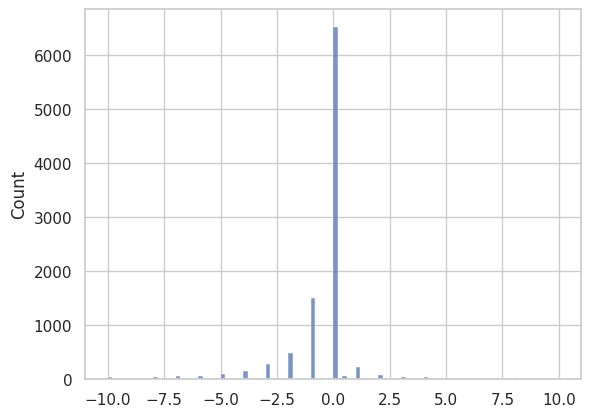

In [83]:
print((sales_pred_true['pred'] - sales_pred_true['true']).describe())
sns.histplot(sales_pred_true['pred'] - sales_pred_true['true'], binrange=[-10,10], bins=100)
print('rmse simple mode().mean()',mean_squared_error(sales_pred_true['true'],sales_pred_true['pred']))

In [84]:
sales_pred_true['pred'] [(sales_pred_true['pred'] - sales_pred_true['true']) > 50]

187414    57.142857
194375    57.142857
Name: pred, dtype: float64

In [ ]:
sns.boxplot(df[df['item_id']==	2707]['item_cnt_month'])

In [ ]:
df = merged[merged['item_id']==22045].sort_values(by='date_block_num')[['date_block_num','item_cnt_month']]

In [ ]:
a=df.groupby('date_block_num').agg({'item_cnt_month':'mean'}).reset_index()
plt.plot(a['date_block_num'],a['item_cnt_month'])

In [ ]:
df = merged[merged['item_id']==2244].sort_values(by='date_block_num')[['date_block_num','item_cnt_month']]

In [ ]:
a=df.groupby('date_block_num').agg({'item_cnt_month':'mean'}).reset_index()
plt.plot(a['date_block_num'],a['item_cnt_month'])

In [ ]:
#big errors when item entered data (both for first prediction and few next monthes)
#may be a good idea to delete first 1-3 monthes

In [88]:
df[ df['item_id'] in df[df['first_date_block_num'] == 10]['item_id']]#choose elemnents that were first time sold in 10 month

569671      1495
569694     10994
569696     11034
569698     10961
569709     13577
           ...  
1608032    14228
1608033     5671
1608051    14227
1608143    15521
1608161    21622
Name: item_id, Length: 50497, dtype: int64